# Project 3 Matrix Factorization

We'll be implementing a couple matrix factorization techniques using semi-homemade techniques, then compare our results to the SVD algorithms in the Surprise recommender library

## Initialize and Prepare Data

For this project we'll bring back the digital music dataset from Amazon.  One of the strengths of this dataset is its density, making it a little easier on our system's RAM.

### Subset Music Ratings

We'll pull in ratings from the top 1000 users and songs.  Not every song has a rating from a top 1000 user and vice-versa so the matrix won't be symmetric.

In [126]:
from surprise import SVD
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp
from sklearn.utils.extmath import randomized_svd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import random
import plotly.plotly as py
import plotly.graph_objs as go

random.seed(7)

path = 'https://raw.githubusercontent.com/TheFedExpress/DATA612/master/Project1/ratings_Digital_Music.csv'
videos_raw = (pd.read_csv(path, names = ['userId', 'itemId', 'rating', 'timestamp'])
    .drop(columns = 'timestamp')
)

def top_n(df, username, itemname, n_user, n_item):
    top_items = df.groupby(itemname).size().sort_values(ascending = False).head(n_item)
    top_users = df.groupby(username).size().sort_values(ascending = False).head(n_user)
    
    subset = (df.set_index(itemname)
        .loc[top_items.index]
        .reset_index()
        .set_index(username)
        .loc[top_users.index]
        .reset_index()
        .dropna()
    )
    return subset

music_full = top_n(videos_raw, 'userId', 'itemId', 1000, 1000)
music_train, music_test = train_test_split(music_full, test_size = .3, random_state = 7)
music_test.set_index(['userId', 'itemId'], inplace = True)

sigma = ((music_test.rating - music_test.rating.mean())**2).mean()**.5
print("Sigma of Test Set: {:.2f}".format(sigma))#For a baseline comparison

Sigma of Test Set: 1.04


### Prepare User-Item Matrix

We'll add biases and baseline predictors.  For the standard SVD factorization, we'll want to feed a matrix with cells equal to:
- If The Item has been rated by the user: the actual rating minus the baseline rating
- If the item has not been rated by the user: 0

In [128]:
def calc_bias(df, column):
    df = df.copy()
    df[column + '_bias'] = df.rating - df.rating_avg
    return df

def calc_avg(df, col):
    df = df.copy()
    avg = df[col].mean()
    df['rating_avg'] = avg
    return df

music = music_train.pipe(calc_avg, 'rating')

user_bias = music.groupby('userId').mean().pipe(calc_bias, 'user')
item_bias = music.groupby('itemId').mean().pipe(calc_bias, 'item')

music = (music
    .join(item_bias.item_bias, on = 'itemId')
    .join(user_bias.user_bias, on = 'userId')
)


def predict_val(df):
    df = df.copy()
    df['baseline'] = df.rating_avg + df.item_bias + df.user_bias 
    df['r_hat'] = df.rating - df.baseline
    df['r_pred'] = df.rating + df.baseline
    df['r_capped'] = df['r_pred'].map(lambda x: min(max(x, 0),5))
    return df

music =  music.pipe(predict_val)

ui_matrix = music.pivot(index = 'userId', columns = 'itemId', values = 'r_hat')
print("Shape: {}" .format(ui_matrix.shape))
ui_matrix.head(10)

Shape: (745, 953)


itemId,5555991584,B00000016T,B00000016W,B0000002ME,B00000050T,B00000053X,B00000064E,B00000064F,B00000064G,B0000009OU,...,B00HRN0C7E,B00HUAP0NK,B00HWJX2R0,B00IKS2BHY,B00IOVH8AW,B00IXZ9QP4,B00JH1W452,B00JJOG5D4,B00JRBLSR2,B00JYKU6BK
userId,,,,,,,,,,,,,,,,,,,,,
A103KNDW8GN92L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103W7ZPKGOCC9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105S56ODHGJEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10DYTGIWV3RJZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10XJR7CWHNKWU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11F8B8GQURI84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11L90R7RWJA8H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11P8ZZN2NRL27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11YRHINAJNUQJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.802401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### SVD

We'll use randomized SVD from the sklearn library (I believe this subclasses SVD from SciPy).  Though it's not relevent with our data, Randomized SVD allows the user-item matrix to be stored in compressed form; tuples of item, user, rating.  It also doesn't require inverting an uncompressed user-item matrix so it is considerably faster on large data.

To choose the number of components to start with, we'll take a look at the gamma values, known as singular values.  These indicate how much variance is examplained by each latent dimension.  Our goal is to find the point at which the marginal value of each additional latent dimension is low.  To do so, we want to find where a plot of singular values by index forms an "elbow".  Cutting off the latent dimensions at this point will find the correct balance of variance expination and overfitting (bias variance tradeoff).

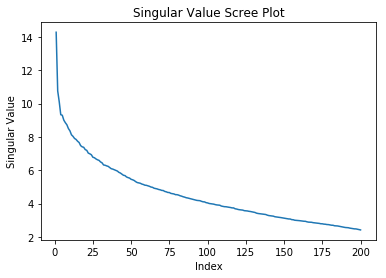

In [104]:
_, gamma, _ = randomized_svd(ui_matrix.fillna(0).values, n_components = 200)
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,201)], gamma)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Scree Plot')
plt.show()

*This plot elbows around dimension 25.  The slope further smooths out around dimension 50.  Any number in that area would be a reasonable choice.*

In [129]:
U, gamma, VT = randomized_svd(ui_matrix.fillna(0).values, n_components = 25)

reconstruction = np.matmul(np.matmul(U, np.diag(gamma)), VT)
new_frame = (pd.DataFrame(reconstruction, columns = ui_matrix.columns, index = ui_matrix.index)
    .reset_index()
    .melt(id_vars = ['userId'])
    .rename(columns = {'value': 'rating'})
    .join(item_bias[['item_bias', 'rating_avg']], on = 'itemId')
    .join(user_bias.user_bias, on = 'userId')
    .pipe(predict_val)
    .set_index(['userId', 'itemId'])
)
new_frame_test = new_frame.join(music_test, on = ['userId', 'itemId'], how = 'inner', 
    lsuffix = 'pred', rsuffix = 'actual')

rmse1 = ((new_frame_test.r_capped - new_frame_test.ratingactual) ** 2).mean()**.5
print("SVD RMSE:{:.3f}".format(rmse1))

SVD RMSE:0.894


### SGD

There is an implementation of SGD found at: http://www.albertauyeung.com/post/python-matrix-factorization/

SGD allows for missing values in the user-item matrix, so imputation is not necesary.  Biases are accounted for in the algorithm, requiring less data preparation beforehand.  The algorithm uses two parameters, learning rate and regularization, both of which could be tuned with a grid search if one were so inclined.

This implemenation expects NAs set to 0, but we alter it to allow for NAs, so that zeros don't get mixed into any averages that calculate bias.

In [106]:
#SGD algo
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where((np.isnan(self.R)== 0))])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if np.isnan(self.R[i, j]) == 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        self.R_zero = np.nan_to_num(self.R)
        xs, ys = self.R_zero.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

We'll start with the user-item matrix and let the algorithm account for biases. The learning rate is relatively low so 200 iterations is necessary.

In [130]:
ui_matrix2 = music.pivot(index = 'userId', columns = 'itemId', values = 'rating')
mf = MF(ui_matrix2.values, K = 25, alpha=.001, beta=.1, iterations=200)
mf.train()
sgd_matrix = mf.full_matrix()
def sgd_cap(df):
    df = df.copy()
    df['r_capped'] = df['rating'].map(lambda x: min(max(x, 0),5))
    return df

new_sgd = (pd.DataFrame(sgd_matrix, columns = ui_matrix.columns, index = ui_matrix.index)
    .reset_index()
    .melt(id_vars = ['userId'])
    .rename(columns = {'value': 'rating'})
    .pipe(sgd_cap)
    .set_index(['userId', 'itemId'])
)
sgd_test = new_sgd.join(music_test, on = ['userId', 'itemId'], how = 'inner', 
    lsuffix = 'pred', rsuffix = 'actual')

rmse2 = ((sgd_test.r_capped - sgd_test.ratingactual) ** 2).mean()**.5
print("SGD RMSE:{:.3f}".format(rmse2))

SGD RMSE:0.830


With regulization and better treatment of biases, the SGD algorithm outperforms standard SVD.

## Surprise Implementations

The SVD algorithm in the Surprise package is actually the FunkSVD method, which is confusingly named.  FunkSVD is actually an implementation of SGD, not SVD.


Descriptions can be found here: <br>
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [108]:
param_grid = {'n_factors' : [15,25, 50, 100], 'reg_all': [.1],
'lr_all': [.001],
'n_epochs': [200]                                                         
}

reader = Reader(rating_scale=(1, 5))
music_data = Dataset.load_from_df(music_train, reader)
trainset = music_data.build_full_trainset()

def cv_search(model_type, param_grid, data):
    param_list = ['param_' + key for key in param_grid.keys()] + ['mean_test_rmse']
    cv = GridSearchCV(model_type, param_grid, cv = 3, n_jobs = -1)
    cv.fit(data)
    results_df = (pd.DataFrame(cv.cv_results)[param_list]
        .sort_values('mean_test_rmse')
    )
    return results_df


We train with the same regularization and learning rating we used in the previous example.  We'll grid search over "n_factors" to optimizae that hyperparameter.

### FunkSVD

In [109]:
cv_search(SVD, param_grid, music_data)

,param_n_factors,param_reg_all,param_lr_all,param_n_epochs,mean_test_rmse
0,15,0.1,0.001,200,0.875606
1,25,0.1,0.001,200,0.876235
2,50,0.1,0.001,200,0.877478
3,100,0.1,0.001,200,0.879582


### SVD++

This algorithm is similar to FunkSVD, but adds an additional factor vector that accounts for implicit ratings.  Implicit ratings are defined by Surprise as *"implicit rating describes the fact that a user u rated an item j, regardless of the rating value."*<br>
The effect should be to add to the personalization of ratings.  Relying on item bias might over-account for the opinion of the masses so this should inch us a little close to a personalized rating.

The Surprise implementation doesn't include the "neighborhood" set of terms that were used by the Netflix Prize SVD++
(Section 5)<br>
https://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf

In [110]:
cv_search(SVDpp, param_grid, music_data)

,param_n_factors,param_reg_all,param_lr_all,param_n_epochs,mean_test_rmse
0,15,0.1,0.001,200,0.875886
1,25,0.1,0.001,200,0.877471
2,50,0.1,0.001,200,0.879007
3,100,0.1,0.001,200,0.885762


*RMSEs from our semi-scratch implementations are inline with the Surprise package*

## Conclusion and Next Steps

With matrix factorization, there intiallly appeared to be two reasonable approaches to making recommendations:

1. Using the reconstructed ratings matrix (with ratings predictions for unstreamed songs), the highest predicted rating for unstreamed songs could be used.
2. The user vector in the U matrix could be compared directly to song vectors in the V matrix.  This is because they are mapped to the same "preference space".

We will see why the first method is the only reasonable choice.

*Method 1:*

In [111]:

best_svd = SVDpp(n_factors = 25, reg_all = .1, n_epochs = 200, lr_all = .001)
best_svd.fit(trainset)

testset = trainset.build_anti_testset()
predictions = (pd.DataFrame(best_svd.test(testset), columns = ['userId', 'itemId', 'act_rating', 'Predicted Rating', 'details'])
    .drop(columns = ['act_rating', 'details'])
    .set_index(['userId', 'itemId'])
)
predictions.loc['A103W7ZPKGOCC9'].sort_values(by = 'Predicted Rating', ascending = False).head(10)

,Predicted Rating
itemId,
B00000JNNY,5.0
B00006C2H3,5.0
B0000025RI,5.0
B000006045,5.0
B00009N1ZV,5.0
B0013L5M08,5.0
B004PVH8I2,5.0
B000002KHB,5.0
B000001FAO,5.0


**Note:** Once the model is trained, it would be reasonable to allow predictions to exceed 5 becuase this would result in arbitrary recommendation tie-breakers for users with many ratings predicted at 5.

*Method 2:*

This method will not take the user and item biases into account so the recommendations will be quite different than the predicted ratings method.  It would recommend purely by genre.  This is not really desirable, as it would sometimes recommend low-quality songs simply because they are in the user's genre sweet spot.

In [112]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = pd.DataFrame(cosine_similarity(mf.P, mf.Q), columns = ui_matrix.columns, index = ui_matrix.index)

*Comparison*

We see the difference between the two recommendation methods.  Top recommendations based on "song space" are not even close to the top of the predicted rating rankings.

In [113]:
sim_long =  (sim_matrix.reset_index()
    .melt(id_vars = ['userId'])
    .rename(columns = {'value': 'similarity'})
    .set_index(['userId', 'itemId'])
    .join(predictions, on = ['userId', 'itemId'])
)
sim_long.loc['A11P8ZZN2NRL27'].sort_values('similarity', ascending = False).head(10)

,similarity,Predicted Rating
itemId,,
B007FNN9BW,0.608150,NaN
B000002LFZ,0.578701,4.424593
B00002MZ2C,0.576197,4.876890
B00000K51T,0.564315,4.403164
B00000DQSF,0.541704,4.809852
B000067CPX,0.481791,4.685920
B0000AGWJ7,0.480261,4.155411
B00006ISBT,0.462637,4.622938
B00000A6JS,0.461137,4.643595


### Next Steps

Adding a time component to our model would bring us close to the Netflix Prize implementation.  For more advanced mappings of songs and users to a song space, embeddings could be used.  This would capture nonlinear trends and possibly provide better predictions. 